In [33]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from dataset import CUB200Dataset, SOPDataset
from torch.utils.data import DataLoader
from model import RaMBO_backbone
from sklearn.metrics.pairwise import cosine_distances

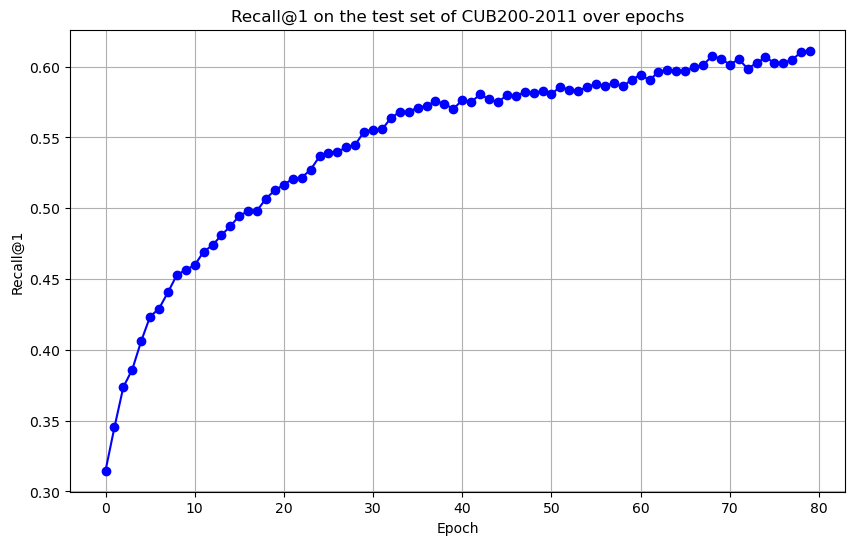

In [34]:
# Read data from file
file_path = 'CUB200_64.txt'
epochs = []
recalls = []

with open(file_path, 'r') as file:
    lines = file.readlines()
    for line in lines:
        parts = line.split(': Recall@1 = ')
        epoch = int(parts[0].split(' ')[1]) - 1
        recall = float(parts[1])
        epochs.append(epoch)
        recalls.append(recall)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, recalls, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Recall@1')
plt.title('Recall@1 on the test set of CUB200-2011 over epochs')
plt.grid(True)
plt.show()

In [37]:
import os
import pandas as pd
import numpy as np
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics.pairwise import cosine_distances
import random

class CUB200Dataset(Dataset):
    def __init__(self, root_dir, train=True, transform=None):
        self.root_dir = root_dir
        self.train = train
        self.transform = transform
        self.image_paths, self.labels = self._load_metadata()

    def _load_metadata(self):
        images_file = os.path.join(self.root_dir, 'images.txt')
        labels_file = os.path.join(self.root_dir, 'image_class_labels.txt')
        train_test_file = os.path.join(self.root_dir, 'train_test_split.txt')

        images = pd.read_csv(images_file, sep=' ', header=None, names=['img_id', 'filepath'])
        labels = pd.read_csv(labels_file, sep=' ', header=None, names=['img_id', 'label'])
        train_test_split = pd.read_csv(train_test_file, sep=' ', header=None, names=['img_id', 'is_train'])

        data = images.merge(labels, on='img_id')
        data = data.merge(train_test_split, on='img_id')

        if self.train:
            data = data[data['is_train'] == 1]
        else:
            data = data[data['is_train'] == 0]

        image_paths = data['filepath'].values
        labels = data['label'].values - 1  # Labels should start from 0

        return image_paths, labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, 'images', self.image_paths[idx])
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label, self.image_paths[idx]

def get_cub200_dataloaders(root_dir, batch_size=32, num_workers=4, transform=None):
    if transform is None:
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.CenterCrop((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    test_dataset = CUB200Dataset(root_dir=root_dir, train=False, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return test_loader

# Path to the dataset
root_dir = 'dataset/CUB_200_2011'
test_loader = get_cub200_dataloaders(root_dir, batch_size=32, num_workers=4)

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = RaMBO_backbone(embedding_dim=512)
dataset = "CUB200"

model.load_state_dict(torch.load(f'checkpoint/{dataset}/best_model.pth'))
model = model.to(device)

In [36]:
test_dataset = CUB200Dataset(
            root_dir='dataset/CUB_200_2011', train=False)
test_dataloader = DataLoader(test_dataset, shuffle=True, num_workers=4)

In [38]:
def extract_embeddings(model, dataloader, device):
    model.eval()
    embeddings = []
    labels = []
    image_names = []
    with torch.no_grad():
        for images, lbls, paths in dataloader:
            images = images.to(device)
            outputs = model(images)
            embeddings.append(outputs.cpu().numpy())
            labels.append(lbls.cpu().numpy())
            image_names.extend(paths)
    embeddings = np.vstack(embeddings)
    labels = np.hstack(labels)
    return embeddings, labels, image_names

test_embeddings, test_labels, test_image_names = extract_embeddings(model, test_loader, device)

In [39]:
# Randomly select three images from the test set
random_indices = random.sample(range(len(test_embeddings)), 3)

# Compute pairwise distances
distances = cosine_distances(test_embeddings)

# Find the nearest 3 neighbors for each of the three selected images
nearest_neighbors = {idx: np.argsort(distances[idx])[1:4] for idx in random_indices}

# Retrieve names and classes of the nearest neighbors
def get_neighbors_info(image_names, labels, nearest_neighbors):
    neighbors_info = []
    for idx, neighbors in nearest_neighbors.items():
        info = {
            "image": image_names[idx],
            "class": labels[idx],
            "neighbors": []
        }
        for neighbor in neighbors:
            neighbor_info = {
                "neighbor_image": image_names[neighbor],
                "neighbor_class": labels[neighbor]
            }
            info["neighbors"].append(neighbor_info)
        neighbors_info.append(info)
    return neighbors_info

neighbors_info = get_neighbors_info(test_image_names, test_labels, nearest_neighbors)

for info in neighbors_info:
    print(f"Image: {info['image']}, Class: {info['class']}")
    for neighbor in info["neighbors"]:
        print(f"  Neighbor Image: {neighbor['neighbor_image']}, Neighbor Class: {neighbor['neighbor_class']}")

Image: 016.Painted_Bunting/Painted_Bunting_0054_16711.jpg, Class: 15
  Neighbor Image: 016.Painted_Bunting/Painted_Bunting_0081_15230.jpg, Neighbor Class: 15
  Neighbor Image: 016.Painted_Bunting/Painted_Bunting_0021_15295.jpg, Neighbor Class: 15
  Neighbor Image: 016.Painted_Bunting/Painted_Bunting_0013_15294.jpg, Neighbor Class: 15
Image: 118.House_Sparrow/House_Sparrow_0063_111460.jpg, Class: 117
  Neighbor Image: 115.Brewer_Sparrow/Brewer_Sparrow_0065_107419.jpg, Neighbor Class: 114
  Neighbor Image: 115.Brewer_Sparrow/Brewer_Sparrow_0037_107442.jpg, Neighbor Class: 114
  Neighbor Image: 043.Yellow_bellied_Flycatcher/Yellow_Bellied_Flycatcher_0029_795483.jpg, Neighbor Class: 42
Image: 194.Cactus_Wren/Cactus_Wren_0116_185927.jpg, Class: 193
  Neighbor Image: 194.Cactus_Wren/Cactus_Wren_0004_185797.jpg, Neighbor Class: 193
  Neighbor Image: 194.Cactus_Wren/Cactus_Wren_0042_185514.jpg, Neighbor Class: 193
  Neighbor Image: 194.Cactus_Wren/Cactus_Wren_0101_185627.jpg, Neighbor Class: 1

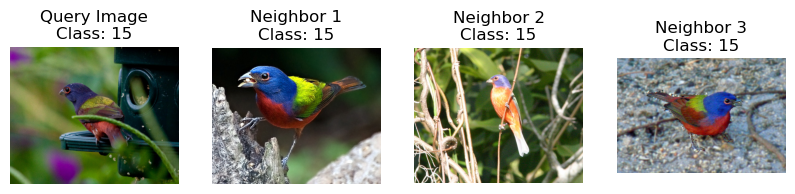

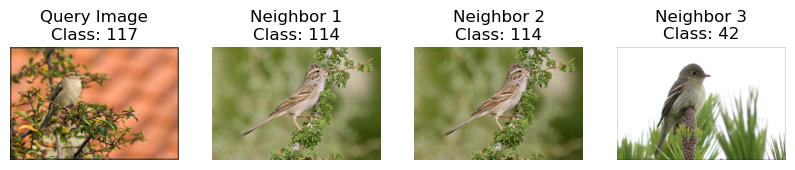

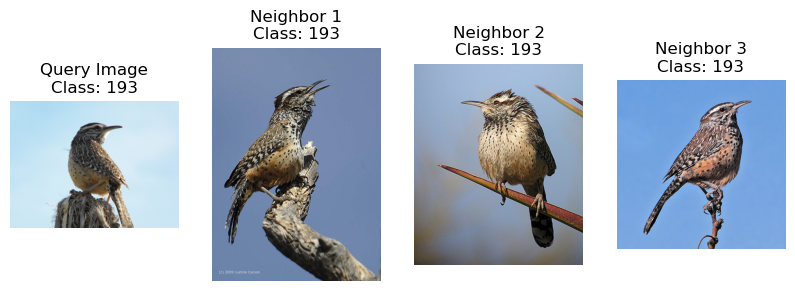

In [40]:
# Load an image by its path
def load_image(image_path, root_dir):
    img_path = os.path.join(root_dir, 'images', image_path)
    image = Image.open(img_path).convert('RGB')
    return image

# Plot the query images and their nearest neighbors
def plot_neighbors(root_dir, neighbors_info):
    for info in neighbors_info:
        query_image = load_image(info["image"], root_dir)
        
        plt.figure(figsize=(10, 5))
        # Show the query image
        plt.subplot(1, 4, 1)
        plt.imshow(query_image)
        plt.title(f'Query Image\nClass: {info["class"]}')
        plt.axis('off')
        
        # Show the nearest neighbors
        for j, neighbor in enumerate(info["neighbors"]):
            neighbor_image = load_image(neighbor["neighbor_image"], root_dir)
            plt.subplot(1, 4, j + 2)
            plt.imshow(neighbor_image)
            plt.title(f'Neighbor {j+1}\nClass: {neighbor["neighbor_class"]}')
            plt.axis('off')
        
        plt.show()

plot_neighbors(root_dir, neighbors_info)

In [44]:
class SOPDataset(Dataset):
    def __init__(self, root_dir, train=True, transform=None):
        self.root_dir = root_dir
        self.train = train
        self.transform = transform
        self.image_paths, self.labels = self._load_metadata()

    def _load_metadata(self):
        if self.train:
            metadata_file = os.path.join(self.root_dir, 'Ebay_train.txt')
        else:
            metadata_file = os.path.join(self.root_dir, 'Ebay_test.txt')

        # Read the metadata file
        data = pd.read_csv(metadata_file, sep=' ', header=0)

        # Extract image paths and labels
        image_paths = data['path'].values
        labels = data['class_id'].values - 1  # Labels should start from 0

        return image_paths, labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_paths[idx])
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label, self.image_paths[idx]

def get_sop_dataloaders(root_dir, batch_size=1, num_workers=4, transform=None):
    if transform is None:
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.CenterCrop((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    test_dataset = SOPDataset(root_dir=root_dir, train=False, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return test_loader

# Path to the dataset
root_dir = 'dataset/Stanford_Online_Products'
test_loader = get_sop_dataloaders(root_dir, batch_size=32, num_workers=4)

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = RaMBO_backbone(embedding_dim=512)
dataset = "SOP"

model.load_state_dict(torch.load(f'checkpoint/{dataset}/best_model.pth'))
model = model.to(device)

In [46]:
test_embeddings, test_labels, test_image_names = extract_embeddings(model, test_loader, device)

In [47]:
# Randomly select three images from the test set
random_indices = random.sample(range(len(test_embeddings)), 3)

# Compute pairwise distances
distances = cosine_distances(test_embeddings)

# Find the nearest 3 neighbors for each of the three selected images
nearest_neighbors = {idx: np.argsort(distances[idx])[1:4] for idx in random_indices}

# Retrieve names and classes of the nearest neighbors
def get_neighbors_info(image_names, labels, nearest_neighbors):
    neighbors_info = []
    for idx, neighbors in nearest_neighbors.items():
        info = {
            "image": image_names[idx],
            "class": labels[idx],
            "neighbors": []
        }
        for neighbor in neighbors:
            neighbor_info = {
                "neighbor_image": image_names[neighbor],
                "neighbor_class": labels[neighbor]
            }
            info["neighbors"].append(neighbor_info)
        neighbors_info.append(info)
    return neighbors_info

neighbors_info = get_neighbors_info(test_image_names, test_labels, nearest_neighbors)

for info in neighbors_info:
    print(f"Image: {info['image']}, Class: {info['class']}")
    for neighbor in info["neighbors"]:
        print(f"  Neighbor Image: {neighbor['neighbor_image']}, Neighbor Class: {neighbor['neighbor_class']}")

Image: fan_final/311428620520_0.JPG, Class: 15257
  Neighbor Image: fan_final/311211125854_0.JPG, Neighbor Class: 15231
  Neighbor Image: fan_final/311425007904_0.JPG, Neighbor Class: 15250
  Neighbor Image: fan_final/391094860333_1.JPG, Neighbor Class: 15410
Image: mug_final/271946521472_2.JPG, Class: 17945
  Neighbor Image: mug_final/271946521472_1.JPG, Neighbor Class: 17945
  Neighbor Image: mug_final/301708903206_3.JPG, Neighbor Class: 18336
  Neighbor Image: kettle_final/252027170736_6.JPG, Neighbor Class: 15573
Image: lamp_final/331569884483_4.JPG, Class: 17225
  Neighbor Image: coffee_maker_final/252055004353_8.JPG, Neighbor Class: 14174
  Neighbor Image: coffee_maker_final/291519881157_8.JPG, Neighbor Class: 14481
  Neighbor Image: kettle_final/361363147521_2.JPG, Neighbor Class: 16262


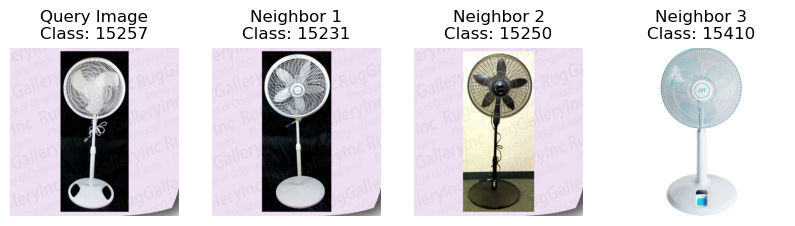

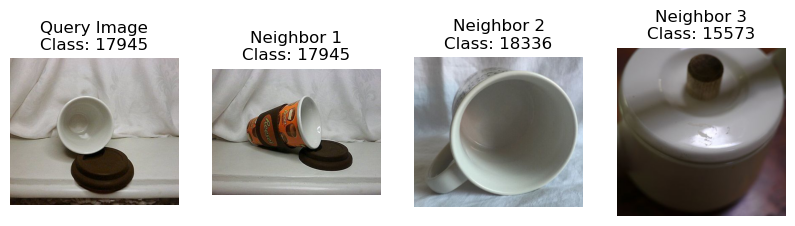

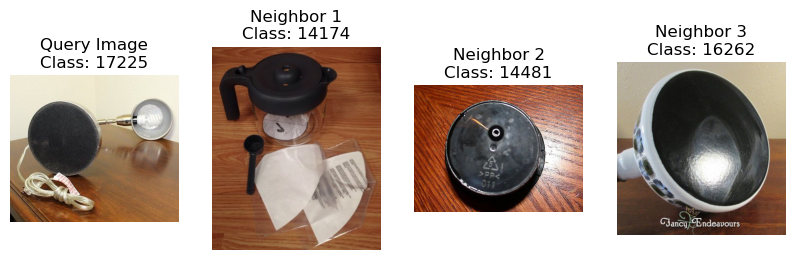

In [49]:
# Load an image by its path
def load_image(image_path, root_dir):
    img_path = os.path.join(root_dir, image_path)
    image = Image.open(img_path).convert('RGB')
    return image

# Plot the query images and their nearest neighbors
def plot_neighbors(root_dir, neighbors_info):
    for info in neighbors_info:
        query_image = load_image(info["image"], root_dir)
        
        plt.figure(figsize=(10, 5))
        # Show the query image
        plt.subplot(1, 4, 1)
        plt.imshow(query_image)
        plt.title(f'Query Image\nClass: {info["class"]}')
        plt.axis('off')
        
        # Show the nearest neighbors
        for j, neighbor in enumerate(info["neighbors"]):
            neighbor_image = load_image(neighbor["neighbor_image"], root_dir)
            plt.subplot(1, 4, j + 2)
            plt.imshow(neighbor_image)
            plt.title(f'Neighbor {j+1}\nClass: {neighbor["neighbor_class"]}')
            plt.axis('off')
        
        plt.show()
plot_neighbors(root_dir, neighbors_info)